In [6]:
import os, sys, random, glob, cv2, math
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from IPython.display import clear_output

In [2]:
# Global settings
%matplotlib inline

# Image processing classes

In [3]:
class FaceDetector(object):
    def __init__(self):
        face_haar_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        if not os.path.isfile(face_haar_path):
            print('Haar cascade file not found!')
        self.face_cascade = cv2.CascadeClassifier(face_haar_path)

    def get_face_from_img(self, img):
        # Method for face detection. Only the first detected face is used. 
        # Various scaling and padding tricks are used to increase the robustness.
        # The cropped face image is returned, or None if face is not found. 

        # Scale the image resolution.
        scaling = 1000 / max(img.shape[0], img.shape[1])
        img = cv2.resize(img, (0,0), fx=scaling, fy=scaling)

        # Add padding to the edges. This is necessary to detect cropped faces
        # with Haar cascades. 
        padding = 200
        pad_color = np.mean(img, axis=(0, 1))
        img = cv2.copyMakeBorder(img, padding, padding, 
                                 padding, padding, 
                                 cv2.BORDER_CONSTANT, value=pad_color)

        # Convert to grayscale and run the detection. 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.2, 5)

        if len(faces) == 0:
            # Face not found. 
            return None

        (x,y,w,h) = faces[0]
        cropped = img[y:y+h, x:x+w, :]
        return cropped
    
    
class CNN_Model(object):
    # Class for the neural network model and related methods. 
    # Model building and image preprocessing is encapsulated in this class. 
    # Feed normal 8bit uint RGB images to the inference method. 
    
    def __init__(self):
        # Load pretrained Resnet model. 
        model = ResNet50(weights='imagenet')

        # Pop the original output and configure the 2048 long feature vector as new output.
        # If necessary, run model.summary() for more details. 
        model.layers.pop()
        last = model.layers[-1].output
        self.model = Model(model.input, last)
        self.model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        # Optimizer, loss and metrics are there just to be able to compile the model. 
            
    def run_inference(self, img):
        x = preprocess_input(img.copy().astype(np.float32))
        vect = self.model.predict(np.expand_dims(x, axis=0), verbose=0) 
        return vect
    
    
class ImageUtils(object):
    def __init__(self):
        self.img_list = []
    
    def load_image(self, file_path):    
        img = cv2.imread(file_path) 
        # Convert to RGB channel order.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       
        return img

    def scale_image(self, img, target_size):
        # target_size = (x, y) resolution.
        fx = target_size[0] / img.shape[1]
        fy = target_size[1] / img.shape[0]
        img = cv2.resize(img, fx=fx, fy=fy, dsize=(0,0))
        return img
    
    def plot_image_row(self, img, img_id=0):
        self.img_list.append((img.copy(), str(img_id)))
        if len(self.img_list) >= 5:          
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 5, figsize=(15, 15))
            for index in range(5):    
                axes[index].imshow(self.img_list[index][0])
                axes[index].axis('off')
                axes[index].set_title(self.img_list[index][1])        
            plt.show()  
            self.img_list = []

    def plot_search_results(self, ref_img_path, best_match_paths):
        def _load_img(img_path):
            img = cv2.imread(img_path) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            return img
        n_img = len(best_match_paths)
        fig, axes = plt.subplots(1, n_img + 1, figsize=(16,6))
        axes[0].imshow(_load_img(ref_img_path))
        axes[0].set_title('Search reference')
        axes[0].axis('off')

        for i in range(1, n_img + 1):
            img_path = best_match_paths[i - 1]
            axes[i].imshow(_load_img(img_path))
            if i == 1:
                plt_title = '1st'
            elif i == 2: 
                plt_title = '2nd'
            elif i == 3:
                plt_title = '3rd'
            else:
                plt_title = str(i) + 'th'
            axes[i].set_title( plt_title + ' match')
            axes[i].axis('off')

        plt.show()

class ImageLibrary(object):
    def __init__(self):
        self.img_size = (224, 224) # Image size for the CNN model processing. 
        self.vector_size = 2048 # Dimensions for the CNN output vector
        self.img_lib = []
        self.img_utils = ImageUtils()
        print('Loading face detector.')
        self.face_detector = FaceDetector()
        print('Loading neural network model.')
        self.cnn_model = CNN_Model()
        
    def import_image(self, img_path, add_to_lib=True, plot=True):
        # This method is used to import images to the face feature library. 

        img = self.img_utils.load_image(img_path)
        if img is None:
            print('Error in reading {}'.format(img_path))
            return 
        face_img = self.face_detector.get_face_from_img(img)
        if face_img is None:
            print('Face not found in {}'.format(img_path))
            return
        face_img = self.img_utils.scale_image(face_img, self.img_size)
        face_vector = self.cnn_model.run_inference(face_img)
        if add_to_lib:
            self.img_lib.append((img_path, face_vector))
        if plot: 
            self.img_utils.plot_image_row(face_img, len(self.img_lib) - 1)
        return face_vector
        
    def find_matching_image(self, ref_img_path, n_img=1):
        # This method is for searching best matching images from the library.   
        
        # Put some limits to the max number of results. 
        if n_img <= 0 or n_img > 10: 
            print('n_img must be in range from 1 to 10')
            n_img = 1

        # Load ref image and get the feature vector. 
        ref_vector = self.import_image(ref_img_path, add_to_lib=False, plot=False)
        def distance(vect1, vect2, method='cosine'): 
            if method == 'cosine':
                return spatial.distance.cosine(vect1, vect2)
            elif method == 'euclidean':
                return spatial.distance.euclidean(vect1, vect2)
 
        # Search the matching vector
        n_vectors = len(self.img_lib)
        distance_vector = np.full((n_vectors), 0.)
        for i in range(n_vectors):
            distance_vector[i] = distance(ref_vector, self.img_lib[i][1])

        results = []
        for i in range(n_img):
            result_index = np.nanargmin(distance_vector)
            results.append(self.img_lib[result_index][0])
            # 'Zero' the best result so far
            distance_vector[result_index] = np.max(distance_vector)

        return results 
    
    def plot_stats(self):
        print('The feature library contains face data from {} images'.format(len(self.img_lib)))

    def save_library(self):
        # Todo
        pass
    
    def load_library(self):
        # Todo
        pass
    

# Create the image feature library

In [4]:
# Get the image paths.  
lib_img_paths = glob.glob("Imglib/*.jpg", recursive=False)

# Import image data to the library
lib = ImageLibrary()
for filepath in lib_img_paths:
    lib.import_image(filepath, add_to_lib=True, plot=True)

clear_output(wait=True)
print('Done!')
lib.plot_stats()

Done!
The feature library contains face data from 120 images


# Image search example

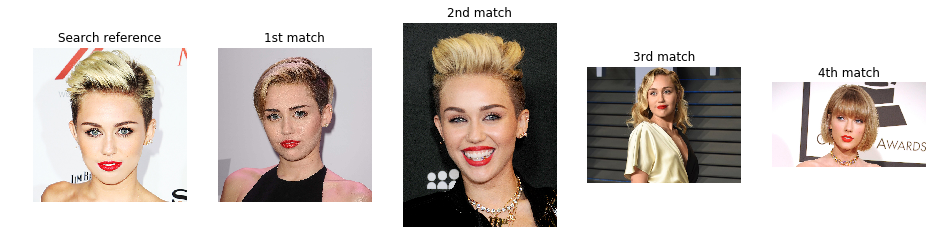

In [5]:
# Give path to the reference image
reference_img_path = 'Test/Miley.jpg'

best_match_filenames = lib.find_matching_image(reference_img_path, 4)
img_utils= ImageUtils()
img_utils.plot_search_results(reference_img_path, best_match_filenames)